# Data preparation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('dataset_for_datascience_assignment.csv')

# Relationship between Early Purchases and Long-Term Purchase Frequency


**Abstract:**

This study examines the relationship between early purchase behavior and purchase frequency. Users were grouped based on the timing of their first purchase—on the first day, within the first week, within 14 days, and during the second week. Purchase frequency was defined as total purchases divided by the time between registration and the last purchase, and users were classified into five frequency groups.

Bar charts showed that most “Very High Frequency” users made purchases within the first week, while two-thirds of “Very Low Frequency” users did not purchase within 14 days. T-tests confirmed that purchases on the first day, within the first week, and within 14 days were significantly associated with higher purchase frequency, but second-week purchases were not.

To compare the effectiveness of first-week vs. 14-day purchase behaviors, users were divided into Week 1, Week 2, and No Early Purchase groups. Week 1 users had the highest purchase frequency, supported by ANOVA. OLS regression showed that both Week 1 and 14-day purchases positively predict frequency, with Week 1 having a slightly stronger effect.

Based on these findings, I recommend refining Wolt’s current strategy (free delivery within 14 days) by adding targeted incentives for first-week purchases to better encourage long-term engagement.


**Introduction:**

This study explores the relationship between the timing of a user's first purchase and their subsequent purchasing behavior. Motivated by Wolt’s current incentive policy—which offers free delivery on the first order made within 14 days of registration—I aim to investigate whether earlier purchases (e.g., within the first day or first week) are more strongly associated with higher long-term purchase frequency. The goal is to evaluate the effectiveness of the existing policy and identify opportunities for optimizing early-stage incentives to better cultivate user habits.

## User Segmentation: Based on First Purchase Time and Registration Time

This analysis segments users based on the time gap between their registration date and their first purchase. Users are categorized into three groups based on their early engagement behavior:

1. Frist-Day Purchase: Users who made their first purchase on the same day as registration.

2. First Week Purchase: Users who made their first purchase within the first week after registration.

3. Purchase Within 14 Days: Users who made their first purchase within the first 14 days after registration.

4. Second Week Purchase: Users who made their first purchase after the first week and within the first 14 days after registration.

In [3]:
# Ensure the date columns are in datetime format
data['FIRST_PURCHASE_DAY'] = pd.to_datetime(data['FIRST_PURCHASE_DAY'], errors='coerce')
data['REGISTRATION_DATE'] = pd.to_datetime(data['REGISTRATION_DATE'], errors='coerce')

# Remove rows where FIRST_PURCHASE_DAY is NaT (i.e., users who never made a purchase)
data = data[data['FIRST_PURCHASE_DAY'].notna()]

# Create a binary column indicating whether the first purchase occurred on the registration day
data['FIRST_DAY_PURCHASE'] = data['REGISTRATION_DATE'] == data['FIRST_PURCHASE_DAY']

# Calculate the number of days between registration and first purchase
data['DAYS_TO_FIRST_PURCHASE'] = (data['FIRST_PURCHASE_DAY'] - data['REGISTRATION_DATE']).dt.days

# Create a binary column for purchases made within the first 7 days after registration
data['FIRST_WEEK_PURCHASE'] = data['DAYS_TO_FIRST_PURCHASE'] <= 7

# Create a binary column for purchases made within the first 14 days after registration
data['PURCHASE_WITHIN_14_DAYS'] = data['DAYS_TO_FIRST_PURCHASE'] <= 14

# Create a binary column for purchases made in the second week
data['SECOND_WEEK_PURCHASE'] = (data['DAYS_TO_FIRST_PURCHASE'] > 7) & (data['DAYS_TO_FIRST_PURCHASE'] <= 14)


### User segmentation overview

In [4]:
# Total number of users after removing those who never purchased
total_users = len(data)

# Create a summary DataFrame for first purchase timing
summary = pd.DataFrame({
    'User Segment': ['Day 1 Purchase', 'Week 1 Purchase', 'Within 14 Days'],
    'User Count': [
        data['FIRST_DAY_PURCHASE'].sum(),
        data['FIRST_WEEK_PURCHASE'].sum(),
        data['PURCHASE_WITHIN_14_DAYS'].sum()
    ]
})

# Add percentage column
summary['Percentage'] = (summary['User Count'] / total_users * 100).round(2)

print(summary)

      User Segment  User Count  Percentage
0   Day 1 Purchase        5835       48.77
1  Week 1 Purchase        6863       57.36
2   Within 14 Days        7225       60.39


C:\Users\lyrgl\AppData\Local\Temp\ipykernel_22084\3902185861.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='User Segment', y='User Count', data=summary, palette='Set2')


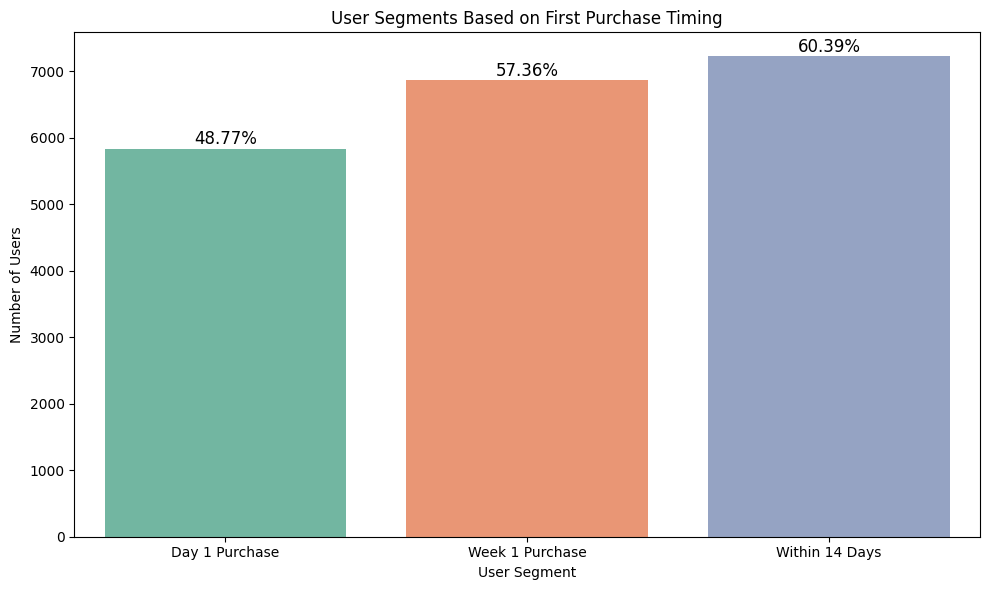

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar plot to visualize the user segments
plt.figure(figsize=(10, 6))

# Bar plot for User Count
sns.barplot(x='User Segment', y='User Count', data=summary, palette='Set2')

# Add a percentage label above the bars
for i, value in enumerate(summary['User Count']):
    plt.text(i, value + 5, f"{summary['Percentage'][i]}%", ha='center', va='bottom', fontsize=12)

plt.title('User Segments Based on First Purchase Timing')
plt.xlabel('User Segment')
plt.ylabel('Number of Users')
plt.tight_layout()

plt.show()


Based on users’ first purchase timing after registration, three segments were created. The distribution of users in each segment is as follows:

- Day 1 Purchasers: 5,835 users (approximately 49%) made their first purchase on the same day they registered.

- Week 1 Purchasers: 6,863 users (approximately 57%) placed their first order within 7 days of registration.

- 14 days Purchasers: 7,225 users (approximately 60%) completed their first order within 14 days of signing up.

These figures suggest that a significant portion of users engage with the platform early, with more than half making their first purchase within the first week. The increase in user count from Day 1 to Week 1 and from Week 1 to Week 2 indicates that extending promotional offers beyond the first day may effectively capture a larger group of active users.



## Purchases Frequency

### Definition: purchase frequency

Although the data includes the field 'AVG_DAYS_BETWEEN_PURCHASES', the average interval between purchases does not necessarily capture the full picture of purchase frequency.

- Average Purchase Interval: This is calculated as the average number of days between two consecutive purchases. While this can give an idea of how often a user buys something, it doesn't account for the total number of purchases made over a certain period. For instance, if someone makes two purchases very close together (e.g., one day apart) and then no purchases for a long time, the average interval might be quite large, but the frequency would still be low because the total number of purchases is limited.

- Purchase Frequency: This is calculated as the total number of purchases divided by the total number of days a user has been active. This gives a more accurate measure of how often a user makes a purchase on average, which is the actual definition of frequency. It takes into account both the number of purchases and the length of time over which those purchases occurred. So, a user who makes 10 purchases over a 30-day period would have a higher frequency than someone who makes 10 purchases over 100 days, even though their average intervals between purchases could be the same.

### User Segments according to purchase frequency

To gain deeper insights into long-term consumer behavior, a purchase frequency metric was constructed. This metric reflects how frequently users placed orders during their active usage period on the platform. The number of active days was calculated as the time span between each user's registration date and their last recorded purchase. Purchase frequency was then defined as the number of purchases divided by the number of active days.

Only users with at least one purchase were included in this analysis to ensure interpretability.

In [6]:
# Convert registration and last purchase date to datetime
data['REGISTRATION_DATE'] = pd.to_datetime(data['REGISTRATION_DATE'])
data['LAST_PURCHASE_DAY'] = pd.to_datetime(data['LAST_PURCHASE_DAY'])

# Calculate the number of days a user has been using Wolt
data['USAGE_DAYS'] = (data['LAST_PURCHASE_DAY'] - data['REGISTRATION_DATE']).dt.days

# Calculate the purchase frequency (purchases per day)
data['PURCHASE_FREQUENCY'] = data['PURCHASE_COUNT'] / data['USAGE_DAYS']

# Filter out users with 0 purchases (PURCHASE_COUNT == 0)
data_non_zero = data[data['PURCHASE_COUNT'] > 0]

Based on the calculated frequency, users were categorized into three segments:

- Very High Frequency: Users who make purchases at least once a day (≥ 1 purchase per day).

- High Frequency: Users who make purchases at least every two weeks (≥ 1 purchase every 14 days).

- Moderate Frequency: Users who make purchases at least once a month (≥ 1 purchase every 30 days).

- Low Frequency: Users who make purchases at least once every two months (≥ 1 purchase every 60 days).

- Very Low Frequency: Users who make purchases less than once every two months (< 1 purchase every 60 days).

FREQUENCY_CATEGORY_GRANULAR
Very Low Frequency     4436
Very High Frequency    2402
Low Frequency          2276
Moderate Frequency     1605
High Frequency         1245
Name: count, dtype: int64


C:\Users\lyrgl\AppData\Local\Temp\ipykernel_22084\1846765334.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='FREQUENCY_CATEGORY_GRANULAR', data=data_non_zero, palette='coolwarm', order=category_order)


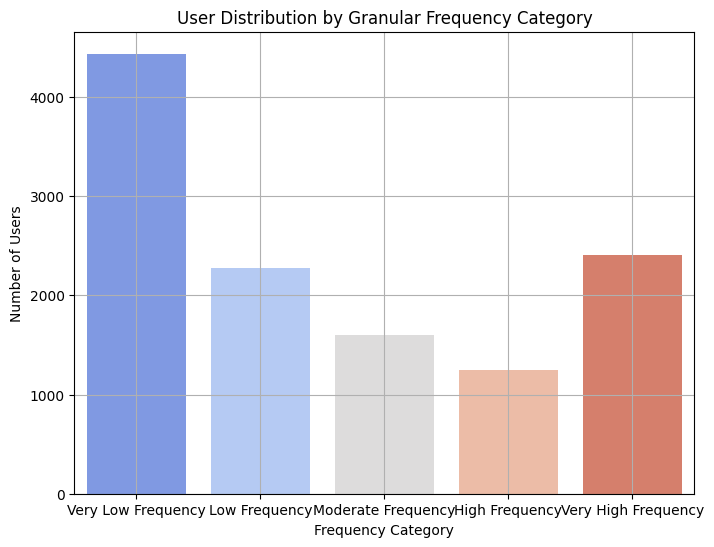

In [7]:
# High Frequency (>= 1 purchase per day) 
# Moderate Frequency (0.1 <= PURCHASE_FREQUENCY < 1 per day)
# Low Frequency (< 0.1 purchase per day) -> 10 days 1 purchase
data_non_zero['FREQUENCY_CATEGORY_GRANULAR'] = data_non_zero['PURCHASE_FREQUENCY'].apply(
    lambda x: 'Very High Frequency' if x >= 1 else 
              ('High Frequency' if x >= 1/14 else 
               ('Moderate Frequency' if x >= 1/30 else 
                ('Low Frequency' if x >= 1/60 else 'Very Low Frequency')))
)


# Check the distribution of users in each more granular category
granular_distribution = data_non_zero['FREQUENCY_CATEGORY_GRANULAR'].value_counts()
print(granular_distribution)

# Define the desired order for the categories
category_order = ['Very Low Frequency', 'Low Frequency', 'Moderate Frequency', 'High Frequency', 'Very High Frequency']

# Visualize the more granular distribution with ordered x-axis
plt.figure(figsize=(8, 6))
sns.countplot(x='FREQUENCY_CATEGORY_GRANULAR', data=data_non_zero, palette='coolwarm', order=category_order)
plt.title('User Distribution by Granular Frequency Category')
plt.xlabel('Frequency Category')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()


### Visualization: Frequency Category vs Early Purchase

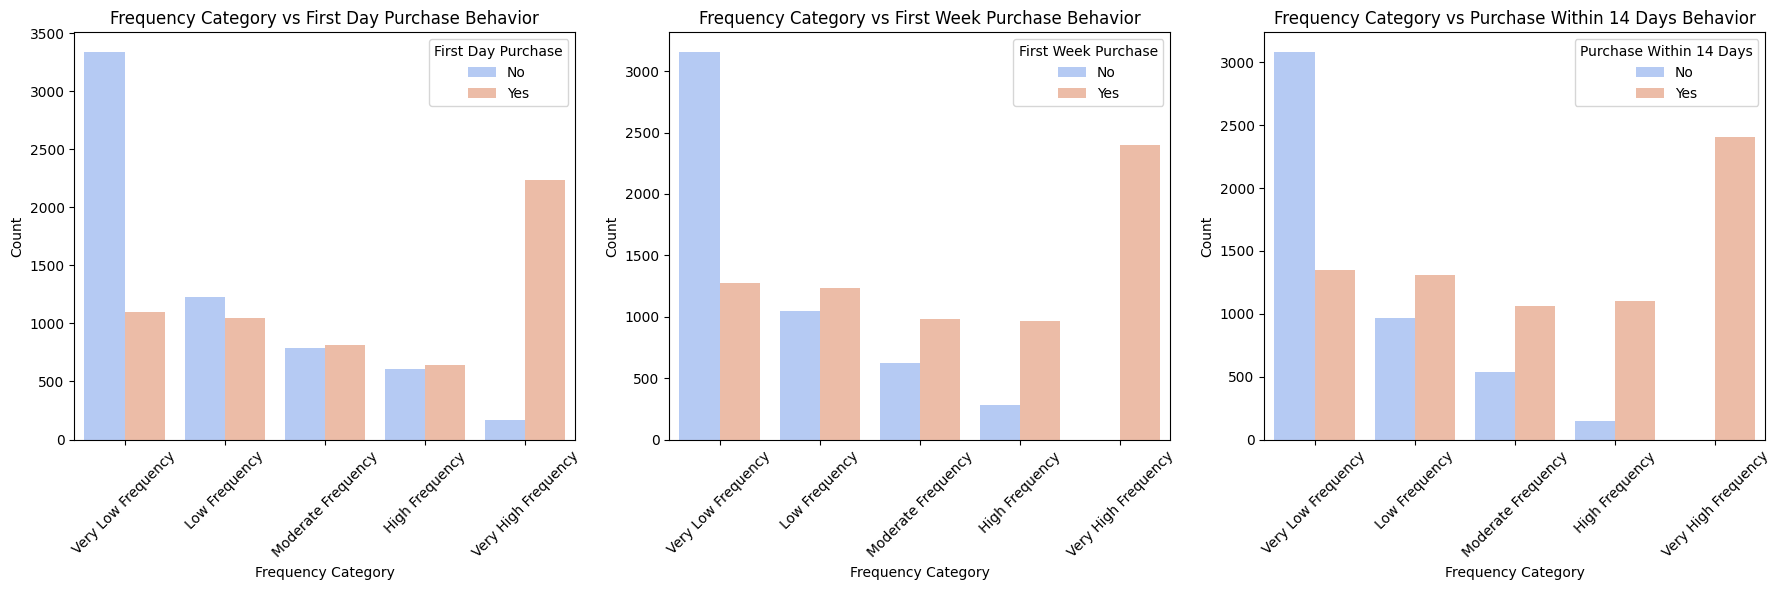

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order of frequency categories
category_order = ['Very Low Frequency', 'Low Frequency', 'Moderate Frequency', 'High Frequency', 'Very High Frequency']

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Frequency Category vs First Day Purchase
sns.countplot(x='FREQUENCY_CATEGORY_GRANULAR', hue='FIRST_DAY_PURCHASE', data=data_non_zero, palette='coolwarm', ax=axes[0], order=category_order)
axes[0].set_title('Frequency Category vs First Day Purchase Behavior')
axes[0].set_xlabel('Frequency Category')
axes[0].set_ylabel('Count')
axes[0].legend(title='First Day Purchase', labels=['No', 'Yes'])
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Plot for Frequency Category vs First Week Purchase
sns.countplot(x='FREQUENCY_CATEGORY_GRANULAR', hue='FIRST_WEEK_PURCHASE', data=data_non_zero, palette='coolwarm', ax=axes[1], order=category_order)
axes[1].set_title('Frequency Category vs First Week Purchase Behavior')
axes[1].set_xlabel('Frequency Category')
axes[1].set_ylabel('Count')
axes[1].legend(title='First Week Purchase', labels=['No', 'Yes'])
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Plot for Frequency Category vs Purchase Within 14 Days
sns.countplot(x='FREQUENCY_CATEGORY_GRANULAR', hue='PURCHASE_WITHIN_14_DAYS', data=data_non_zero, palette='coolwarm', ax=axes[2], order=category_order)
axes[2].set_title('Frequency Category vs Purchase Within 14 Days Behavior')
axes[2].set_xlabel('Frequency Category')
axes[2].set_ylabel('Count')
axes[2].legend(title='Purchase Within 14 Days', labels=['No', 'Yes'])
axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Adjust layout
plt.tight_layout()
plt.show()


**Interpretation:**

Comparing Chart 1 and Chart 2, we observe that within the "very high frequency" group, although some individuals did not make a purchase on the first day, almost all of them made a purchase within the first week.

From the third chart, we can see that two-thirds of the people in the "very low frequency" group did not make any purchases within the first 14 days.

There is a significant difference in early purchase behavior between the "very low" and "very high" frequency groups.

## T-Test: early purchase and long-term purchase frequency

To assess whether early purchasing behavior is associated with long-term user engagement, independent two-sample t-tests were conducted comparing the average purchase frequency between users who made purchases early and those who did not.

The following comparisons were tested:

- Users who made a purchase on their registration day vs. those who did not

- Users who made a purchase within the first week of registration vs. those who did not

- Users who made a purchase within the first 14 days of registration vs. those who did not

- Users who made a purchase in the second week of registration vs. those who did not

In [9]:
# filter users whose frequency is inf or NaN
data_cleaned = data[~data['PURCHASE_FREQUENCY'].isin([float('inf'), float('nan')])]
data_cleaned = data[data['USAGE_DAYS'] > 0]

In [10]:
from scipy import stats
import pandas as pd

t_test_results = []

# define table
tests = {
    "First Day Purchase": 'FIRST_DAY_PURCHASE',
    "First Week Purchase": 'FIRST_WEEK_PURCHASE',
    "Purchase Within 14 Days": 'PURCHASE_WITHIN_14_DAYS',
    "Second Week Purchase": 'SECOND_WEEK_PURCHASE'
}

# t test and store the results
for label, col in tests.items():
    group_yes = data_cleaned[data_cleaned[col] == True]['PURCHASE_FREQUENCY']
    group_no = data_cleaned[data_cleaned[col] == False]['PURCHASE_FREQUENCY']
    t_stat, p_value = stats.ttest_ind(group_yes, group_no)
    t_test_results.append({
        "Test": label,
        "T-statistic": round(t_stat, 4),
        "P-value": "{:.2e}".format(p_value)
    })


t_test_df = pd.DataFrame(t_test_results)

t_test_df


,Test,T-statistic,P-value
0,First Day Purchase,7.6207,2.76e-14
1,First Week Purchase,24.5852,1.41e-129
2,Purchase Within 14 Days,23.9820,1.45e-123
3,Second Week Purchase,-1.4618,1.44e-01


**Interpretation:**

The t-test results reveal significant insights into the relationship between early purchase behavior and subsequent purchase frequency:

- First Day Purchase: There is a significant difference in the purchase frequency between users who made a purchase on the first day of registration and those who did not. This suggests that users who purchase on their first day tend to have a higher purchase frequency later on.

- First Week Purchase: Similarly, users who made a purchase within the first week after registration show a significantly higher purchase frequency compared to those who did not make a purchase in the first week. This reinforces the idea that early purchases, particularly within the first week, are a strong predictor of later purchase behavior.

- Purchase Within 14 Days: Users who made a purchase within the first 14 days also exhibit a significantly higher purchase frequency than those who did not. This further supports the notion that early purchases (within the first two weeks) have a lasting impact on subsequent buying habits.

- Second Week Purchase (8-14 Days): In contrast, no significant difference in purchase frequency was found between users who made a purchase in the second week (8-14 days) and those who did not. This suggests that purchases made during the second week are not as influential in predicting future purchase behavior as those made in the first week.

**Conclusion:**

Purchasing behavior within the first day and the first week is significantly associated with higher long-term purchase frequency, while purchases made in the second week (8-14 days) show no significant effect.

The first week appears to be the most critical time period for predicting a user's future purchasing behavior, making it a more important factor than purchases made in the second week.

Since both the first week and 14-day purchase show significance, the next step is to refine the distinction between these two time periods. This will allow for a more nuanced approach to targeting marketing strategies, as understanding the specific impact of early purchases within these windows can help optimize promotional efforts.


## Week 1 and Week 2

### Visualization: average purchase frequency by early purchase group

Since the results for the first week and the first 14 days are quite similar in the t-test, I will now further refine the analysis as follows:

To examine the impact of early purchase behavior on long-term purchasing frequency, users were categorized into three groups based on their first purchase timing:

- Week 1: Users who made a purchase within the first week of registration

- Week 2: Users who made a purchase within the first two weeks but not in the first week

- No Early Purchase: Users who did not make a purchase within the first two weeks

C:\Users\lyrgl\AppData\Local\Temp\ipykernel_22084\1597217573.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['EARLY_PURCHASE_GROUP'] = data.apply(classify_user, axis=1)


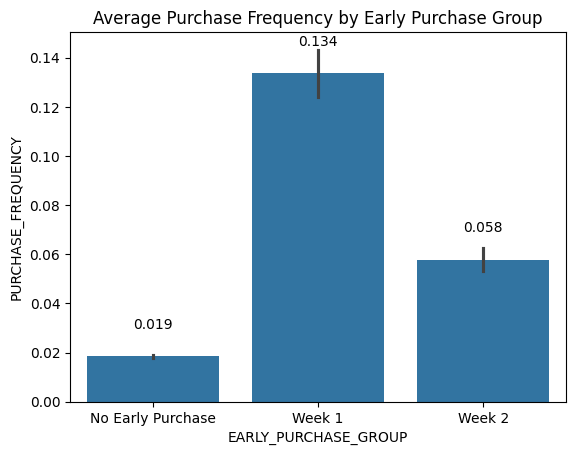

In [11]:
def classify_user(row):
    if row['FIRST_WEEK_PURCHASE']:
        return 'Week 1'
    elif row['PURCHASE_WITHIN_14_DAYS']:
        return 'Week 2'
    else:
        return 'No Early Purchase'

data_cleaned['EARLY_PURCHASE_GROUP'] = data.apply(classify_user, axis=1)

# Create the bar plot
sns.barplot(x='EARLY_PURCHASE_GROUP', y='PURCHASE_FREQUENCY', data=data_cleaned)

# Title
plt.title('Average Purchase Frequency by Early Purchase Group')

# Calculate the average frequency for each group
mean_values = data_cleaned.groupby('EARLY_PURCHASE_GROUP')['PURCHASE_FREQUENCY'].mean().values

# Add the average frequency values on top of the bars
for i, mean in enumerate(mean_values):
    # Only add text if mean is a finite number
    if pd.notna(mean) and mean != float('inf') and mean != float('-inf'):
        plt.text(i, mean + 0.01, f'{mean:.3f}', ha='center', va='bottom')

# Show the plot
plt.show()


A bar plot was generated to visualize the average purchase frequency across these three groups. The results are as follows:

- Week 1 users exhibit the highest average purchase frequency, around 0.134.

- Week 2 users have a significantly lower frequency of about 0.058.

- No Early Purchase users demonstrate the lowest average frequency, at approximately 0.019. 

This analysis indicates a clear positive relationship between early purchase behavior and long-term purchasing frequency. Users who engage early, particularly within the first week, tend to show much higher frequency of purchase, suggesting that early engagement could be a strong indicator of future high-frequency consumption.



### ANOVA

Although the bar chart shows clear differences, the average frequency provides only an initial insight into these variations. However, it is not sufficient to establish causal relationships. Therefore, an ANOVA test is still necessary.

Null Hypothesis (H0): There is no difference between the three groups.

In [12]:
from scipy import stats
import pandas as pd

# Perform one-way ANOVA to check if there's a significant difference in frequencies
week_groups = data_cleaned['EARLY_PURCHASE_GROUP']
frequencies = data_cleaned['PURCHASE_FREQUENCY']

# ANOVA test
f_stat, p_value = stats.f_oneway(
    frequencies[week_groups == 'Week 1'],
    frequencies[week_groups == 'Week 2'],
    frequencies[week_groups == 'No Early Purchase']
)
anova_results = pd.DataFrame({
    'Statistic': ['F-statistic', 'P-value'],
    'Value': [f_stat, p_value]
})


anova_results

,Statistic,Value
0,F-statistic,3.075558e+02
1,P-value,2.779157e-130


**Interpretation:**

Although the t-test shows that second-week purchases alone do not significantly predict purchase frequency, the ANOVA test across the three groups (Week 1, Week 2, No Early Purchase) reveals significant overall differences. This is largely driven by the high frequency associated with Week 1 purchasers compared to the other groups.

### OLS regression: Purchase Frequency ~ Week 1/ First 14 days

Since users who made a purchase in the first week tend to have higher average purchase frequency later on, I want to explore the correlation between whether a user made a purchase in Week 1 and their subsequent purchase frequency.

In [13]:
import statsmodels.api as sm

# Convert FIRST_WEEK_PURCHASE to numeric type
data_cleaned['FIRST_WEEK_PURCHASE'] = data_cleaned['FIRST_WEEK_PURCHASE'].astype(int)

# Independent variable X and dependent variable Y
X = data_cleaned['FIRST_WEEK_PURCHASE']
Y = data_cleaned['PURCHASE_FREQUENCY']

# Add constant term (intercept) to the model
X = sm.add_constant(X)

# Perform the regression analysis
model_first_week = sm.OLS(Y, X).fit()


C:\Users\lyrgl\AppData\Local\Temp\ipykernel_22084\338128404.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['FIRST_WEEK_PURCHASE'] = data_cleaned['FIRST_WEEK_PURCHASE'].astype(int)


In [14]:
# Convert FIRST_WEEK_PURCHASE to numeric type
data_cleaned['PURCHASE_WITHIN_14_DAYS'] = data_cleaned['PURCHASE_WITHIN_14_DAYS'].astype(int)

# Independent variable X and dependent variable Y
X = data_cleaned['PURCHASE_WITHIN_14_DAYS']
Y = data_cleaned['PURCHASE_FREQUENCY']

# Add constant term (intercept) to the model
X = sm.add_constant(X)

# Perform the regression analysis
model_14_days = sm.OLS(Y, X).fit()

C:\Users\lyrgl\AppData\Local\Temp\ipykernel_22084\3823057315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['PURCHASE_WITHIN_14_DAYS'] = data_cleaned['PURCHASE_WITHIN_14_DAYS'].astype(int)


In [15]:
# Extract key results for both models
results = {
    'Model': ['First Week Purchase', 'Purchase Within 14 Days'],
    'Coefficient': [model_first_week.params['FIRST_WEEK_PURCHASE'], model_14_days.params['PURCHASE_WITHIN_14_DAYS']],
    'Std. Error': [model_first_week.bse['FIRST_WEEK_PURCHASE'], model_14_days.bse['PURCHASE_WITHIN_14_DAYS']],
    't-value': [model_first_week.tvalues['FIRST_WEEK_PURCHASE'], model_14_days.tvalues['PURCHASE_WITHIN_14_DAYS']],
    'p-value': [model_first_week.pvalues['FIRST_WEEK_PURCHASE'], model_14_days.pvalues['PURCHASE_WITHIN_14_DAYS']],
}

# Create DataFrame for easier comparison
df_results = pd.DataFrame(results)

df_results

,Model,Coefficient,Std. Error,t-value,p-value
0,First Week Purchase,0.11230,0.004568,24.585182,1.414996e-129
1,Purchase Within 14 Days,0.10969,0.004574,23.982015,1.451812e-123


**Interpretation:**

- First Week Purchase has a slightly higher coefficient (0.11230) compared to Purchase Within 14 Days (0.10969), which indicates that users who made a purchase within the first week have a slightly higher average purchase frequency than those who made their first purchase within 14 days.

- Both variables have very small p-values (both are well below 0.05), indicating that the results are statistically significant.

- The t-values are also very high, further supporting the statistical significance of both variables.

**Conclusion:**

Since the First Week Purchase group has a slightly higher coefficient and a more significant effect, you could consider focusing more on the first week in your marketing strategy. The results suggest that early purchases within the first week have a slightly stronger relationship with long-term purchase frequency compared to purchases made within the first 14 days.

**Limitation:**

The model’s R-squared value is relatively low, indicating that the registered first-week purchase variable explains only a small portion of the variance in purchase frequency. This could be due to the limited nature of the available data. Specifically, the dataset only provides information on the time gap between registration and the first purchase, without insights into the actual purchase behavior during the first week. If more detailed data, such as the number of purchases made within the first week, were available, it could enhance the model’s ability to capture the nuances of consumer behavior, potentially leading to higher explanatory power.

While the current analysis offers initial insights, the absence of detailed purchase data in the first week represents a significant limitation. In a real-world database, having access to more granular data—such as weekly or monthly purchase frequencies—would allow for a more comprehensive exploration of the relationship between initial purchase behaviors and long-term consumer habits. With this additional data, the model would be able to more effectively capture the impact of early consumption patterns on subsequent purchasing behavior.


In future work, having access to more detailed purchase history, including first-week purchase frequency and subsequent purchase patterns, would likely improve the model’s predictive power. Additionally, incorporating data from user demographics or marketing touchpoints could allow for a deeper understanding of the factors influencing purchase frequency, thereby yielding more actionable insights for business decision-making.

# Conclusion

The t-test results indicate that the first purchase made during the second week after registration are not significantly associated with long-term purchase frequency. In contrast, OLS regression shows that both first-week and 14-day purchases are positively correlated with purchase frequency, with first-week purchases having a slightly stronger effect.

These findings suggest that users who make a purchase within the first week are more likely to develop higher purchasing frequency over time. Therefore, marketing strategies should prioritize capturing these early users.

I recommend refining the current incentive structure by introducing tiered offers: provide free delivery for the first purchase made within the first week, along with a lottery incentive. The lottery could reward users who make an additional purchase within the same week with discounts or another free delivery. This approach may help foster regular purchasing habits. The existing 14-day free delivery incentive can still be maintained to capture a broader base.



Wolt can potentially optimize its free delivery campaign by concentrating benefits in the first 7 days to create stronger user habits and higher retention.